#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо сделать:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
RANDOM_STATE = 42

## Подготовка
На данном этапе необходимо загрузить данные, посмотреть общую информацию о данных и провести ресемплирование.

In [3]:
data =  pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)

In [4]:
print(data.index.is_monotonic)

True


In [5]:
display(data.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data = data.resample('1H').sum()

In [8]:
display(data.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
data_new = data.copy()

### ВЫВОД
Была поведена загрузка данных из файла '/datasets/taxi.csv'. Была праведена провека на хронологию, данные расположены верно. Изначально периодичность даннах составляло 10 минут.Было проведено ресемплирование, теперь периодичность состаляет один час.

## Анализ

In [10]:
print('Начало временного отрезка :',data.index.min())
print('Конец временного отрезка:',data.index.max())
print('Временной отрезок:',data.index.max() - data.index.min())

Начало временного отрезка : 2018-03-01 00:00:00
Конец временного отрезка: 2018-08-31 23:00:00
Временной отрезок: 183 days 23:00:00


In [11]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


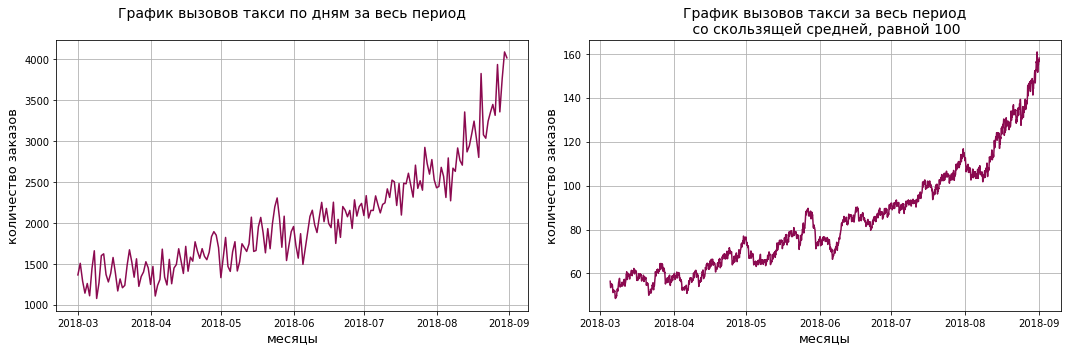

In [12]:
plt.figure(figsize=[15,5])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(121)
plt.plot(data.resample('1D').sum(),color = '#8B0A50')
plt.title ("График вызовов такси по дням за весь период\n", fontsize=14)
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(122)
plt. plot(data.rolling(100).mean(),color = '#8B0A50')  
plt.title ("График вызовов такси за весь период\n со скользящей средней, равной 100",fontsize=14 );
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.tight_layout()

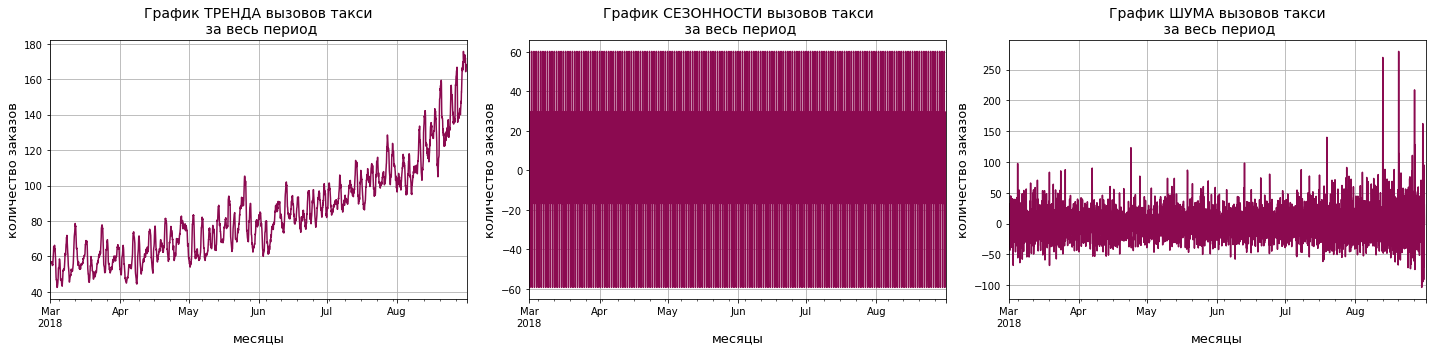

In [13]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=[20,5])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(131)
decomposed.trend.plot(ax=plt.gca(),color = '#8B0A50')
plt.title ("График ТРЕНДА вызовов такси\n за весь период", fontsize=14)
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(132)
decomposed.seasonal.plot(ax=plt.gca(),color = '#8B0A50')  
plt.title ("График СЕЗОННОСТИ вызовов такси\n за весь период",fontsize=14 );
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(133)
decomposed.resid.plot(ax=plt.gca(),color = '#8B0A50')  
plt.title ("График ШУМА вызовов такси\n за весь период",fontsize=14 );
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.tight_layout()

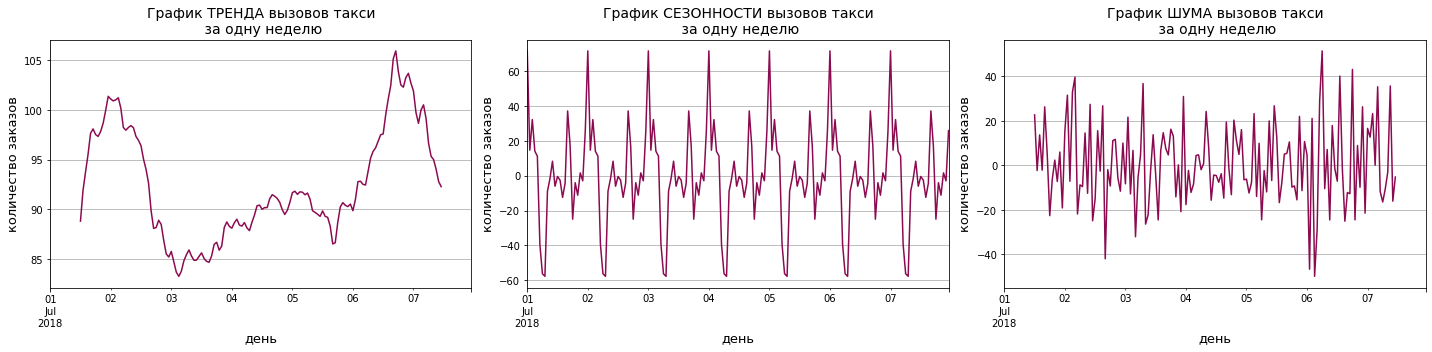

In [14]:
decomposed = seasonal_decompose(data['2018-07-01':'2018-07-07'])

plt.figure(figsize=[20,5])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(131)
decomposed.trend.plot(ax=plt.gca(),color = '#8B0A50')
plt.title ("График ТРЕНДА вызовов такси\n за одну неделю", fontsize=14)
plt.xlabel('день', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(132)
decomposed.seasonal.plot(ax=plt.gca(),color = '#8B0A50')  
plt.title ("График СЕЗОННОСТИ вызовов такси\n за одну неделю",fontsize=14 );
plt.xlabel('день', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(133)
decomposed.resid.plot(ax=plt.gca(),color = '#8B0A50')  
plt.title ("График ШУМА вызовов такси\n за одну неделю",fontsize=14 );
plt.xlabel('день', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.tight_layout()

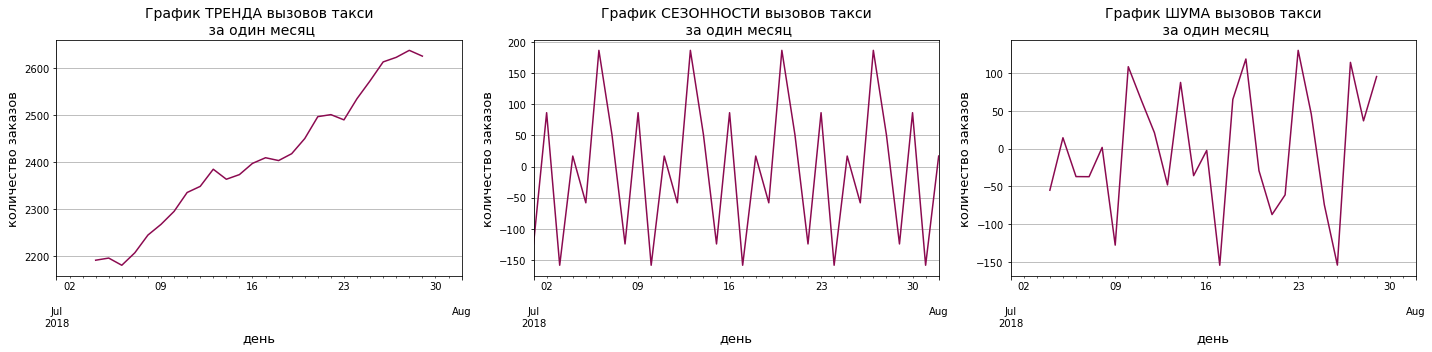

In [15]:
data_1 = data.resample('1D').sum()
decomposed = seasonal_decompose(data_1['2018-07-01':'2018-08-01'])

plt.figure(figsize=[20,5])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(131)
decomposed.trend.plot(ax=plt.gca(),color = '#8B0A50')
plt.title ("График ТРЕНДА вызовов такси\n за один месяц", fontsize=14)
plt.xlabel('день', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(132)
decomposed.seasonal.plot(ax=plt.gca(),color = '#8B0A50')  
plt.title ("График СЕЗОННОСТИ вызовов такси\n за один месяц",fontsize=14 );
plt.xlabel('день', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(133)
decomposed.resid.plot(ax=plt.gca(),color = '#8B0A50')  
plt.title ("График ШУМА вызовов такси\n за один месяц",fontsize=14 );
plt.xlabel('день', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.tight_layout()

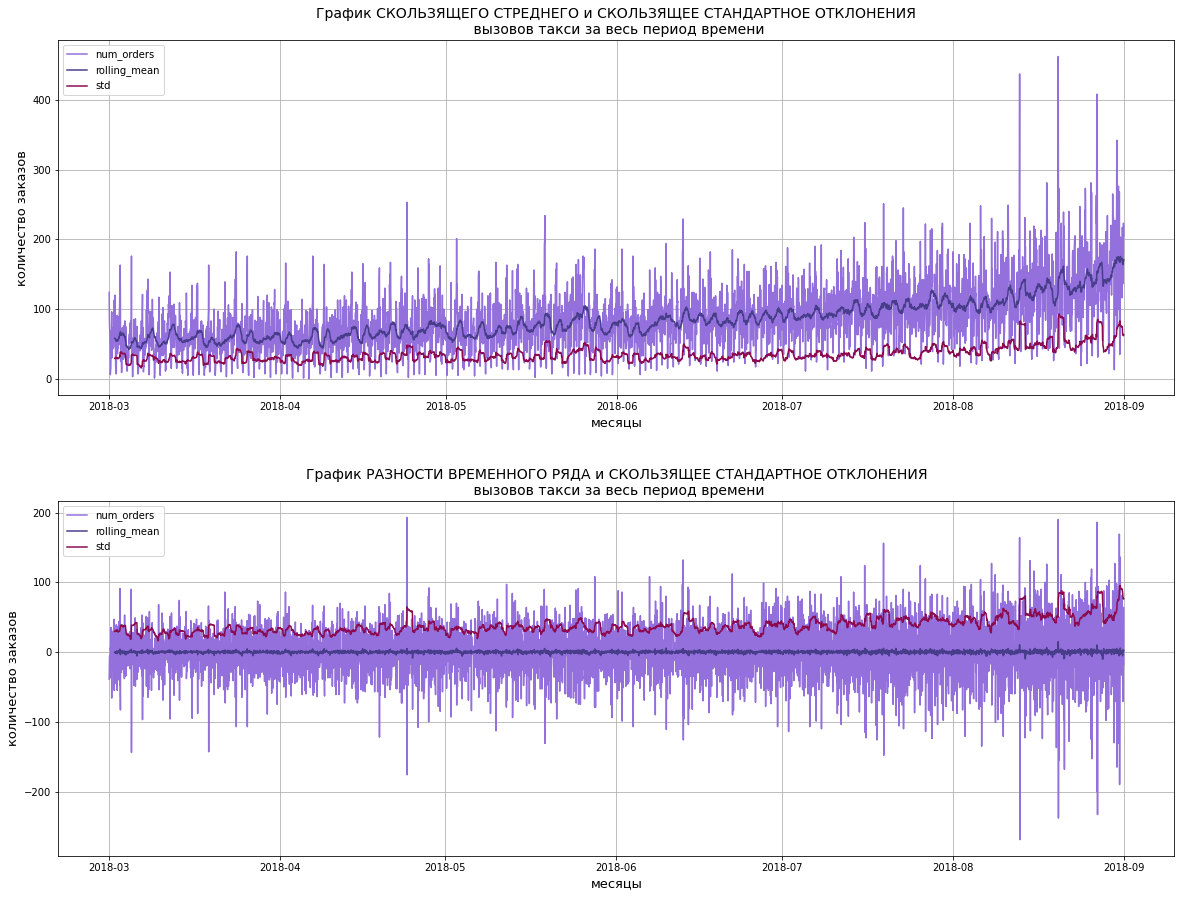

In [16]:
plt.figure(figsize=[20,15])
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.subplot(211)
data_plot = data
data_plot['rolling_mean'] = data_plot.rolling(25).mean()
data_plot['std'] = data_plot['num_orders'].rolling(25).std()
plt.plot(data_plot)
plt.gca().get_lines()[0].set_color("mediumpurple")
plt.gca().get_lines()[0].set_label('num_orders')
plt.gca().get_lines()[1].set_color('#483D8B')
plt.gca().get_lines()[1].set_label('rolling_mean')
plt.gca().get_lines()[2].set_color("#8B0A50")
plt.gca().get_lines()[2].set_label('std')
plt.legend()
plt.title ("График СКОЛЬЗЯЩЕГО СТРЕДНЕГО и СКОЛЬЗЯЩЕЕ СТАНДАРТНОЕ ОТКЛОНЕНИЯ\n вызовов такси за весь период времени", fontsize=14)
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(212)
data_shift = data - data.shift()
data_shift['std'] = data_shift['num_orders'].rolling(25).std()
plt.plot(data_shift)
plt.gca().get_lines()[0].set_color("mediumpurple")
plt.gca().get_lines()[0].set_label('num_orders')
plt.gca().get_lines()[1].set_color('#483D8B')
plt.gca().get_lines()[1].set_label('rolling_mean')
plt.gca().get_lines()[2].set_color("#8B0A50")
plt.gca().get_lines()[2].set_label('std')
plt.title ("График РАЗНОСТИ ВРЕМЕННОГО РЯДА и СКОЛЬЗЯЩЕЕ СТАНДАРТНОЕ ОТКЛОНЕНИЯ\n вызовов такси за весь период времени",fontsize=14 );
plt.xlabel('месяцы', fontsize=13)
plt.legend()
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

Также проведем проверку на стационарность с помощью теста Дики-Фуллера.

Формулировка для теста Дики-Фуллера:

- Нулевая гипотеза(H0): ряд имеет единичный корень.

- Альтернативная гипотеза(H1): ряд не имеет единичного корня.

На выходе будет статистику теста Дики-Фуллера и p-значение. Если p-значение меньше уровня значимости (0.05) , то можно отклонить нулевую гипотезу о нестационарности ряда и считать его стационарным.

In [17]:
adf_test = adfuller(data['num_orders'])

print(f'p-value = {adf_test[1]:.3f}')

alpha = 0.05

if adf_test[1] < alpha :
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Нет оснований отвергнуть нулевую гипотезу')

p-value = 0.029
Отвергаем нулевую гипотезу


### ВЫВОД
Было определено, что начало временного отрезка, собранный данных: 2018-03-01 00:00:00.Конец временного отрезка, собранных данных: 2018-08-31 23:00:00.Сам временной отрезок составляет 183 days 23:00:00.

Было определено, что минимальное количество заказов за один час составляет 0, максимальное количество заказов  - 462.

Был построен график вызовов такси по дням в зависимости от месяца и график со средней скользяшей, равной 100. Данные обладают большими колебаниями, с помощью скользящей было установлено движение вверх.

На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.

Также наблюдается сезонность внутри недели: пик заказов в конце недели вечером, спады - утро рабочих дней.

Была проведена проверка на стационарность с помощью метода Дики-Фуллера. Тест показал, что данные стационарные(p-value = 0.025).

## Обучение

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [19]:
make_features(data, 24, 100)

In [20]:
data = data.dropna()

In [21]:
display(data.head())

,num_orders,rolling_mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,56.46,34.117102,0,4,51.0,32.0,176.0,86.0,68.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0
2018-03-05 05:00:00,16,55.56,34.530518,0,5,34.0,51.0,32.0,176.0,86.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0
2018-03-05 06:00:00,3,54.87,35.421415,0,6,16.0,34.0,51.0,32.0,176.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0
2018-03-05 07:00:00,14,54.19,35.283377,0,7,3.0,16.0,34.0,51.0,32.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0
2018-03-05 08:00:00,31,53.67,34.592726,0,8,14.0,3.0,16.0,34.0,51.0,...,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0


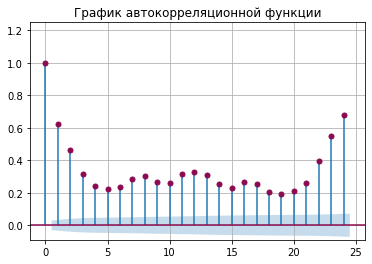

In [22]:
plot_acf(
    data['num_orders'].values.squeeze(),
    lags = 24, 
    auto_ylims = True, 
    use_vlines=True,
    title='График автокорреляционной функции',
    color = '#8B0A50'
);
plt.grid(True)

In [23]:
data = data[['num_orders', 'rolling_mean', 'std', 'dayofweek', 'hour', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_16',
       'lag_17', 'lag_21', 'lag_22', 'lag_23',
       'lag_24']]

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(
    f'Выборка разделена в пропорциях:\n'
    f'{(len(features_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(features_test)/len(data)):.0%} — тестовая;\n'
)

Выборка разделена в пропорциях:
90% — тренировочная;
10% — тестовая;



In [25]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Модель ЛИНЕЙНАЯ РЕГРЕССИЯ

In [26]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

start_1 = time.time()
regression.fit(features_train, target_train)
end_1= time.time()
linear_time = end_1 - start_1

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)



CPU times: user 228 ms, sys: 183 ms, total: 411 ms
Wall time: 337 ms


### Модель ЛЕС РЕШЕНИЙ

In [27]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)

start_1 = time.time()
forest_grid.fit(features_train, target_train)
end_1= time.time()
forest_time = end_1 - start_1

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)

CPU times: user 3min 19s, sys: 269 ms, total: 3min 19s
Wall time: 3min 19s


### Модель ГРАДИЕНТНЫЙ БУСТИНГ 

In [28]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

cb = cb.CatBoostRegressor()

cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }


cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)

start_1 = time.time()
cb_grid.fit(features_train, target_train, verbose=100)
end_1= time.time()
cb_time = end_1 - start_1

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)

0:	learn: 28.8391761	total: 47.9ms	remaining: 47.9s
100:	learn: 17.9022228	total: 177ms	remaining: 1.57s
200:	learn: 16.0400085	total: 303ms	remaining: 1.21s
300:	learn: 14.7870082	total: 428ms	remaining: 995ms
400:	learn: 13.6630065	total: 556ms	remaining: 831ms
500:	learn: 12.6741831	total: 689ms	remaining: 686ms
600:	learn: 11.8424962	total: 841ms	remaining: 558ms
700:	learn: 11.0944987	total: 977ms	remaining: 417ms
800:	learn: 10.3918208	total: 1.12s	remaining: 278ms
900:	learn: 9.7941772	total: 1.27s	remaining: 139ms
999:	learn: 9.2089942	total: 1.4s	remaining: 0us
0:	learn: 31.9387222	total: 2.44ms	remaining: 2.43s
100:	learn: 20.1119036	total: 171ms	remaining: 1.52s
200:	learn: 18.4289073	total: 335ms	remaining: 1.33s
300:	learn: 17.4068023	total: 495ms	remaining: 1.15s
400:	learn: 16.5308812	total: 654ms	remaining: 977ms
500:	learn: 15.8598925	total: 816ms	remaining: 812ms
600:	learn: 15.1769017	total: 980ms	remaining: 651ms
700:	learn: 14.6216662	total: 1.14s	remaining: 488ms


In [29]:
print('Модель ЛИНЕЙНАЯ РЕГРЕССИЯ')
print(f'Время обучения модели : {linear_time:.2f}')
print(f'Среднее качество модели : {regression_cv_score:.2f}\n')

print('Модель ЛЕС РЕШЕНИЙ')
print(f'Время обучения модели : {forest_time:.2f}')
print('Лучшие параметры модели: ', forest_params)
print(f'Среднее качество модели : {forest_score:.2f}\n')

print('Модель ГРАДИЕНТНЫЙ БУСТИНГ')
print(f'Время обучения модели : {cb_time:.2f}')
print('Лучшие параметры модели: ', cb_params)
print(f'Среднее качество модели: {cb_score:.2f}')

Модель ЛИНЕЙНАЯ РЕГРЕССИЯ
Время обучения модели : 0.01
Среднее качество модели : 28.74

Модель ЛЕС РЕШЕНИЙ
Время обучения модели : 199.88
Лучшие параметры модели:  {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 25}
Среднее качество модели : 13.76

Модель ГРАДИЕНТНЫЙ БУСТИНГ
Время обучения модели : 268.92
Лучшие параметры модели:  {'depth': 4, 'learning_rate': 0.03}
Среднее качество модели: 17.45


### ВЫВОД:
На этапе обработки данных был построен график автокорреляционной функции. Было принято решение убрать lags = 5,15,18,19,20.

Были обучены 3 модели и к каждой модели были подобраны гиперпараметры с помощью  GridSearchCV:
- Модель LinearRegression: 
  - Время обучения модели : 0.01
  - Среднее качество модели на кросс-валидации: 28.74
- Модель RandomForestRegressor:
  - Время обучения модели : 204.18
  - Лучшие параметры модели: {'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 25}
  - Среднее качество модели на кросс-валидации: 14.34
- Модель CatBoostRegressor:
  - Время обучения модели : 255.35
  - Лучшие параметры модели: {'depth': 4, 'learning_rate': 0.03}
  - Среднее качество модели на кросс-валидации: 17.45 
  
Исходя из кросс-вальдации лучшая модель  - модель RandomForestRegressor.

## Тестирование

In [30]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 2))

RMSE для проверки модели на адекватность: 59.16


### Модель ЛЕС РЕШЕНИЙ

In [31]:
forest_model = RandomForestRegressor(random_state=RANDOM_STATE,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_predictions = forest_model.predict(features_test)

forest_RMSE = round(RMSE(target_test, forest_predictions), 2)

print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 44.65


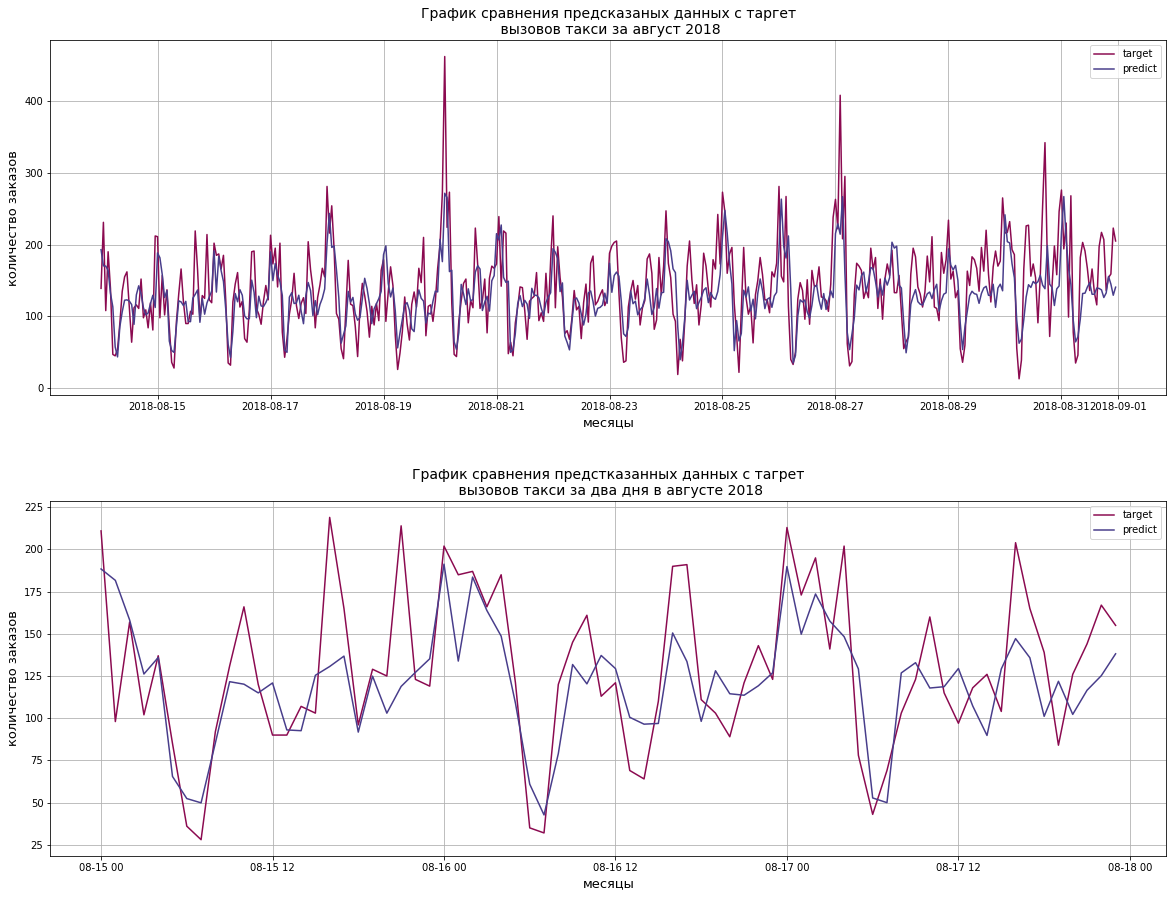

In [32]:
plt.figure(figsize=[20,15])
plt.subplots_adjust(wspace=0.2, hspace=0.3)

model = pd.DataFrame({"target":target_test, "predict":forest_predictions})


plt.subplot(211)

plt.plot(model)
plt.gca().get_lines()[0].set_color("#8B0A50")
plt.gca().get_lines()[0].set_label('target')
plt.gca().get_lines()[1].set_color('#483D8B')
plt.gca().get_lines()[1].set_label('predict')

plt.legend()
plt.title ("График сравнения предсказаных данных с таргет\n вызовов такси за август 2018", fontsize=14)
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

plt.subplot(212)

plt.plot(model['2018-08-15':'2018-08-17'])
plt.gca().get_lines()[0].set_color("#8B0A50")
plt.gca().get_lines()[0].set_label('target')
plt.gca().get_lines()[1].set_color('#483D8B')
plt.gca().get_lines()[1].set_label('predict')
plt.title ("График сравнения предстказанных данных с тагрет\n вызовов такси за два дня в августе 2018",fontsize=14 );
plt.xlabel('месяцы', fontsize=13)
plt.legend()
plt.ylabel('количество заказов', fontsize=13)
plt.grid(True)

### ВЫВОД:
Проверка на адекватность модели показало RMSE = 59.16.

Модель Случайный лес показало RMSE = 44.93, что меньше 48, и это соответсвует требованию.

## ВЫВОД
Необходимо было спрогнозировать количество заказов такси на следующий час.
Для этого было решено ряд задач:

- была поведена загрузка данных из файла '/datasets/taxi.csv'. Была праведена провека на хронологию, данные расположены верно. Изначально периодичность даннах составляло 10 минут.Было проведено ресемплирование, теперь периодичность состаляет один час.

- было определено, что начало временного отрезка, собранный данных: 2018-03-01 00:00:00.Конец временного отрезка, собранных данных: 2018-08-31 23:00:00.Сам временной отрезок составляет 183 days 23:00:00.

- было определено, что минимальное количество заказов за один час составляет 0, максимальное количество заказов  - 462.

- был построен график вызовов такси по дням в зависимости от месяца и график со средней скользяшей, равной 100. Данные обладают большими колебаниями, с помощью скользящей было установлено движение вверх.На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.

- Также наблюдается сезонность внутри недели: пик заказов в конце недели вечером, спады - утро рабочих дней.

- Была проведена проверка на стационарность с помощью метода Дики-Фуллера. Тест показал, что данные стационарные(p-value = 0.025).

- На этапе обработки данных был построен график автокорреляционной функции. Было принято решение убрать lags = 5,15,18,19,20.

- Были обучены 3 модели и к каждой модели были подобраны гиперпараметры с помощью  GridSearchCV:
- Модель LinearRegression: 
  - Время обучения модели : 0.01
  - Среднее качество модели на кросс-валидации: 28.74
- Модель RandomForestRegressor:
  - Время обучения модели : 204.18
  - Лучшие параметры модели: {'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 25}
  - Среднее качество модели на кросс-валидации: 14.34
- Модель CatBoostRegressor:
  - Время обучения модели : 255.35
  - Лучшие параметры модели: {'depth': 4, 'learning_rate': 0.03}
  - Среднее качество модели на кросс-валидации: 17.45 
  
- Исходя из кросс-вальдации лучшая модель  - модель RandomForestRegressor.

- Проверка на адекватность модели показало RMSE = 59.16.

- Модель Случайный лес показало RMSE = 44.93, что меньше 48, и это соответсвует требованию.

Рекомендации:
Для решения поставленной проблемы также можно изучить показатели, связанные с географическим положением работы таксистов, например, около аэропорта, на центре города, в пригородах, около бизнес-центров.